In [1]:
import pygrib, time, os, sys, scipy
import numpy as np
import cartopy as ct
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation
import pymannkendall as mk
import scipy.stats as stats
import statsmodels.api as sm
from datetime import datetime, timedelta

#### Global variables

In [2]:
# initial tracking parameters
top_lat = 50.
right_lon = -40.

# lat/lon bounding box for US east coast
usne_N = 45 # deg lat
usne_S = 33 # deg lat
usne_E = -70 # deg lon
usne_W = -80 # deg lon

# timestepping parameters
dt = 6 # h

#### Functions - loading storm track output

In [3]:
# takes storm tracking dataframe and drops storms that don't reach a min SLP
def SLP_filter(df_out, minSLP):
    df_out = df_out.drop(df_out[df_out['min_p_h (Pa)'] > minSLP].index)
    df_out = df_out.reset_index(drop=True)
    return df_out

In [4]:
# reads CSV file of storm track output into a dataframe
def read_track_csv(year):
    path_base = r"/.../noreasters"
    return pd.read_csv(path_base + '/' + str(year) + '_tracks_final.csv', usecols=np.arange(1, 31))

In [5]:
def read_list(l):
    return [float(n) for n in l[1:-1].split()]

In [6]:
def read_years_SLP(years, minSLP):
    all_df = []
    for year in years:
        all_df.append(SLP_filter(read_track_csv(year), minSLP))
    return all_df

#### Functions - analysis

In [7]:
quantiles = np.arange(0.00, 1.01, 0.01)
deciles = np.arange(0.0, 1.1, 0.1)

In [8]:
def get_quantile(dfi, param, q):
    return np.quantile(dfi[param].to_numpy(), q)

In [9]:
def get_quantile_allyrs(dfs, param, q):
    qvals = []
    for dfi in dfs:
        qvals.append(get_quantile(dfi, param, q))
    return qvals

In [10]:
def quantile_reg(dfs, param, q, alt):
    qvals = get_quantile_allyrs(dfs, param, q)
    return scipy.stats.linregress(allyrs, qvals, alternative=alt)

In [11]:
def quantile_mk(dfs, param, q):
    qvals = get_quantile_allyrs(dfs, param, q)
    return mk.original_test(qvals, alpha=0.05)

In [12]:
def quantile_all_reg(dfs, param, qs, alt):
    regs = []
    for q in qs:
        regs.append(quantile_reg(dfs, param, q, alt))
    return regs

In [13]:
def quantile_all_mk(dfs, param, qs):
    mks = []
    for q in qs:
        mks.append(quantile_mk(dfs, param, q))
    return mks

In [14]:
# helper function for plotting the trend lines on the box plots
def box_trendline(ax, numyrs, slopes, inters, qs, mk=False):
    if mk:
        xyrs = range(numyrs - 1)
    else:
        xyrs = allyrs
    for q in qs:
        regplot = slopes[q]*xyrs + inters[q]
        ax.plot(np.arange(1, numyrs), regplot, label=f'{q/100:.2f} quantile')
    return ax

##  Quantile regression (linear regression for significance test)

In [15]:
# general function for plotting box plot, trends, and significance in one figure
def plot_quantile(dfs, param, qs, pname, plabel, trend_label, qs_plot, alt='greater'):
    zi = 1.644854
    qregs = quantile_all_reg(dfs, param, qs, alt)
    slopes = [i.slope for i in qregs]
    inters = [i.intercept for i in qregs]
    pvals = [i.pvalue for i in qregs]
    stderrs = np.array([i.stderr for i in qregs])
    
    qregs10 = quantile_all_reg(dfs, param, deciles, alt)
    slopes10 = [i.slope for i in qregs10]
    inters10 = [i.intercept for i in qregs10]
    pvals10 = [i.pvalue for i in qregs10]
    stderrs10 = np.array([i.stderr for i in qregs10])
    
    # construct dataframe for boxplot
    yearlist = []
    vlist = []
    for i in range(len(allyrs)):
        year = np.full(len(dfs[i]), allyrs[i])
        vs = dfs[i][param].to_numpy()
        yearlist.append(year)
        vlist.append(vs)
    years = np.concatenate(yearlist, axis=None)
    vl = np.concatenate(vlist, axis=None)
    df_box = pd.DataFrame({'year': years, pname: vl})

    # boxplot
    numyrs = len(dfs)+1
    fig, ax = plt.subplots(figsize=(15, 5))
    ax = box_trendline(ax, numyrs, slopes, inters, qs_plot)
    df_box.boxplot(column=pname, by='year', ax=ax, color='black', whiskerprops=dict(linestyle='--'))
    plt.suptitle('')
    ax.legend()
    ax.set_ylabel(plabel)
    ax.set_xlabel('Year')
    ax.set_title('')
    plt.xticks(np.arange(1, numyrs, 10), np.arange(allyrs[0], allyrs[-1], 10))
    plt.show()

    # quantile trend plots
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(qs, slopes, color='black')
    ax[0].fill_between(qs, slopes - (stderrs*zi), slopes + (stderrs*zi), alpha=0.5, facecolor='gray')
    ax[0].axhline(0, color='gray', linestyle='--')
    ax[0].set_ylabel(trend_label)
    ax[0].set_xlabel('Quantile')
    ax[0].set_title('')
    ax[1].plot(qs, pvals, color='black')
    ax[1].axhline(0.05, color='gray', linestyle='--')
    ax[1].axhline(0.1, color='gray', linestyle='--')
    ax[1].set_ylabel('Significance of trend (p-value)')
    ax[1].set_xlabel('Quantile')
    ax[1].set_title('')
    plt.show()

    # # deciles
    # fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    # ax[0].plot(deciles, slopes10, '-o', color='black')
    # ax[0].fill_between(deciles, slopes10 - (stderrs10*zi), slopes10 + (stderrs10*zi), alpha=0.5, facecolor='gray')
    # ax[0].axhline(0, color='gray', linestyle='--')
    # ax[0].set_ylabel(trend_label)
    # ax[0].set_xlabel('Quantile')
    # ax[0].set_title('')
    # ax[1].plot(deciles, pvals10, color='black')
    # ax[1].axhline(0.05, color='gray', linestyle='--')
    # ax[1].axhline(0.1, color='gray', linestyle='--')
    # ax[1].set_ylabel('Significance of trend (p-value)')
    # ax[1].set_xlabel('Quantile')
    # ax[1].set_title('')
    # plt.show()
    
    return qregs

##  Quantile regression (M-K test for significance test)

In [16]:
# same thing but for Mann-Kendall instead of linear-least squares
def plot_quantile_mk(dfs, param, qs, pname, plabel, trend_label, qs_plot):
    mks = quantile_all_mk(dfs, param, qs)
    slopes = [i.slope for i in mks]
    inters = [i.intercept for i in mks]
    pvals = [i.p/2 for i in mks]

    mks10 = quantile_all_mk(dfs, param, deciles)
    slopes10 = [i.slope for i in mks10]
    inters10 = [i.intercept for i in mks10]
    pvals10 = [i.p/2 for i in mks10]

    # construct dataframe for boxplot
    yearlist = []
    vlist = []
    for i in range(len(allyrs)):
        year = np.full(len(dfs[i]), allyrs[i])
        vs = dfs[i][param].to_numpy()
        yearlist.append(year)
        vlist.append(vs)
    years = np.concatenate(yearlist, axis=None)
    vl = np.concatenate(vlist, axis=None)
    df_box = pd.DataFrame({'year': years, pname: vl})

    # boxplot
    numyrs = len(dfs)+1
    fig, ax = plt.subplots(figsize=(15, 5))
    ax = box_trendline(ax, numyrs, slopes, inters, qs_plot, mk=True)
    df_box.boxplot(column=pname, by='year', ax=ax, color='black', whiskerprops=dict(linestyle='--'))
    plt.suptitle('')
    ax.legend()
    ax.set_ylabel(plabel)
    ax.set_xlabel('Year')
    ax.set_title('')
    plt.xticks(np.arange(1, numyrs, 10), np.arange(allyrs[0], allyrs[-1], 10))
    plt.show()

    # quantile trend plots
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(qs, slopes, color='black')
    ax[0].axhline(0, color='gray', linestyle='--')
    ax[0].set_ylabel(trend_label)
    ax[0].set_xlabel('Quantile')
    ax[0].set_title('')
    ax[1].plot(qs, pvals, color='black')
    ax[1].axhline(0.05, color='gray', linestyle='--')
    ax[1].axhline(0.1, color='gray', linestyle='--')
    ax[1].set_ylabel('Significance of trend (p-value)')
    ax[1].set_xlabel('Quantile')
    ax[1].set_title('')
    plt.show()

    # # deciles
    # fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    # ax[0].plot(deciles, slopes10, '-o', color='black')
    # ax[0].axhline(0, color='gray', linestyle='--')
    # ax[0].set_ylabel(trend_label)
    # ax[0].set_xlabel('Quantile')
    # ax[0].set_title('')
    # ax[1].plot(deciles, pvals10, color='black')
    # ax[1].axhline(0.05, color='gray', linestyle='--')
    # ax[1].axhline(0.1, color='gray', linestyle='--')
    # ax[1].set_ylabel('Significance of trend (p-value)')
    # ax[1].set_xlabel('Quantile')
    # ax[1].set_title('')
    # plt.show()
    
    return mks

In [17]:
# full time interval (1940-2025)
allyrs = np.arange(1940, 2025) # can be adjusted to satellite era (1979-2025)

dfs = read_years_SLP(allyrs, 98000)
for dfi in dfs:
    dfi['tpr_h_500 (m^3/h)'] = dfi['total_precip (m^3)']/dfi['lifetime (h)']
    dfi['tpr_h_750 (m^3/h)'] = dfi['total_precip_750 (m^3)']/dfi['lifetime (h)']
    dfi['tpr_h_1000 (m^3/h)'] = dfi['total_precip_1000 (m^3)']/dfi['lifetime (h)']

mean_ws = []
max_ws = []
min_ws = []

for i in range(len(allyrs)):
    wi = np.mean(dfs[i]['max_w_all_h_750 (m/s)'])  
    mean_ws.append(wi)
    max_ws.append(np.max(dfs[i]['max_w_all_h_750 (m/s)']))
    min_ws.append(np.min(dfs[i]['max_w_all_h_750 (m/s)']))

In [18]:
dfs[-1]

,ID,cx_p,cy_p,c_p (Pa),cx_c,cy_c,passed_USEC,lifetime (h),tot_dist_p (km),tot_dist_c (km),...,max_w_all_h (m/s),max_w_h_750 (m/s),max_w_all_h_750 (m/s),max_w_h_1000 (m/s),max_w_all_h_1000 (m/s),total_precip_750 (m^3),total_precip_1000 (m^3),tpr_h_500 (m^3/h),tpr_h_750 (m^3/h),tpr_h_1000 (m^3/h)
0,12202024-18-73-50,"[73, 84, 99, 107, 106, 117, 125, 135]","[50, 45, 35, 29, 30, 19, 7, 0]","[100162.0625, 99768.5, 99219.0625, 98880.3125,...","[74, 87, 102, 108, 108, 117, 125, 133]","[50, 45, 34, 29, 29, 18, 7, 1]",1,42,1980.436118,1861.805269,...,21.580367,[20.01471026 19.274673 17.23219496 17.729734...,21.580367,[20.01471026 19.274673 17.23219496 17.729734...,21.580367,5.618658e+10,6.852370e+10,6.520415e+08,1.337776e+09,1.631517e+09
1,01102025-12-3-80,"[3, 12, 23, 44, 67, 85, 98, 111, 126, 144, 159...","[80, 79, 82, 63, 55, 49, 46, 44, 47, 47, 42, 3...","[100824.75, 100753.4375, 100807.375, 100319.62...","[2, 8, 20, 44, 67, 85, 98, 112, 126, 143, 159,...","[82, 79, 79, 65, 56, 49, 46, 44, 46, 47, 42, 3...",2,90,5375.242682,5243.420249,...,28.907410,[13.74956346 14.56837654 14.12027222 14.478791...,28.907410,[13.74956346 14.56837654 14.12027222 14.478791...,28.907410,1.034390e+11,1.213600e+11,7.173351e+08,1.149322e+09,1.348444e+09
2,01192025-18-52-56,"[52, 71, 95, 113, 127]","[56, 44, 30, 16, 0]","[100326.125, 99998.875, 99348.9375, 98668.875,...","[54, 75, 95, 113, 127]","[55, 44, 30, 16, 1]",2,24,2217.257466,2148.177792,...,19.717417,[19.20449978 19.02241444 19.16588822 19.717416...,19.896217,[19.20449978 19.02241444 19.16588822 19.717416...,19.896217,2.616917e+10,3.546292e+10,6.757251e+08,1.090382e+09,1.477622e+09
3,02092025-06-72-43,"[72, 95, 109, 134, 148, 168, 175]","[43, 38, 32, 24, 19, 9, 0]","[100655.8125, 100229.3125, 99277.1875, 98358.0...","[73, 93, 112, 134, 149, 166, 175]","[44, 38, 32, 24, 18, 9, 1]",1,36,2464.964935,2415.130861,...,28.181567,[17.23776708 17.9273484 18.10629372 18.818148...,28.181567,[17.23776708 17.9273484 18.10629372 18.818148...,28.181567,4.078922e+10,4.508973e+10,8.800536e+08,1.133034e+09,1.252492e+09
4,02132025-06-30-37,"[30, 43, 58, 93, 115, 119, 142, 144]","[37, 26, 20, 23, 13, 7, 2, 0]","[100349.375, 100288.5, 100119.3125, 99799.6875...","[31, 44, 59, 95, 112, 120, 140, 145]","[36, 27, 18, 22, 13, 7, 3, 1]",2,42,2648.325558,2599.473508,...,22.062576,[12.45092629 12.26844248 12.47765358 12.843369...,22.062576,[12.45092629 12.67738734 13.02195815 13.271843...,22.062576,4.257833e+10,5.604527e+10,5.585462e+08,1.013770e+09,1.334411e+09
5,02152025-18-0-53,"[0, 1, 21, 40, 54, 72, 93, 102, 103, 104, 106,...","[53, 58, 49, 41, 32, 33, 19, 10, 10, 7, 7, 1, 0]","[100978.1875, 100028.125, 99574.75, 99116.1875...","[6, 3, 21, 35, 52, 78, 94, 103, 103, 104, 106,...","[50, 57, 50, 41, 36, 30, 19, 10, 10, 6, 7, 2, 1]",3,72,3587.184271,3688.291280,...,22.745103,[ 8.70801612 9.63140429 9.66375397 9.505205...,23.162312,[11.76724291 11.59245215 11.34110515 11.029791...,23.510529,7.989751e+10,1.051250e+11,7.277579e+08,1.109688e+09,1.460069e+09
6,02202025-06-64-66,"[64, 78, 92, 103, 117, 130, 147, 160, 188, 200]","[66, 57, 51, 44, 36, 28, 20, 17, 1, 0]","[100663.5625, 100179.1875, 99392.5625, 98777.0...","[64, 79, 92, 104, 117, 131, 146, 161, 187, 196]","[65, 57, 51, 44, 36, 28, 21, 17, 2, 3]",2,54,3367.124747,3267.798245,...,27.847228,[19.53556641 18.59315015 19.02758992 19.341544...,27.847228,[19.53556641 18.59315015 19.02758992 19.341544...,27.847228,5.509534e+10,6.940177e+10,7.304561e+08,1.020284e+09,1.285218e+09


### Check autocorrelation

Text(0, 0.5, 'Correlation')

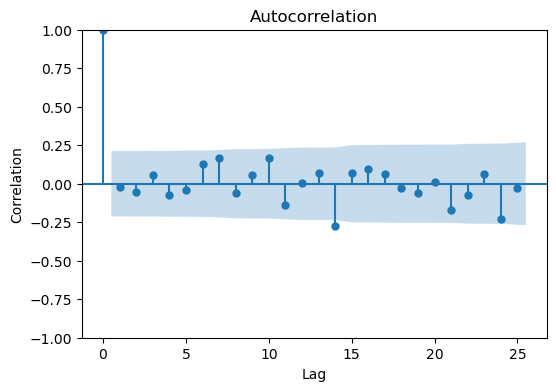

In [19]:
slope, intercept, _, _, _ = stats.linregress(allyrs, mean_ws)
mean_ws_detrended = mean_ws - (slope * allyrs + intercept)

fig, ax = plt.subplots(figsize=(6, 4))
# sm.graphics.tsa.plot_acf(mean_ws, lags=25, ax=ax)
sm.graphics.tsa.plot_acf(mean_ws_detrended, lags=25, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Correlation')

# Fig. 3: Linear-least squares regression (750 km)

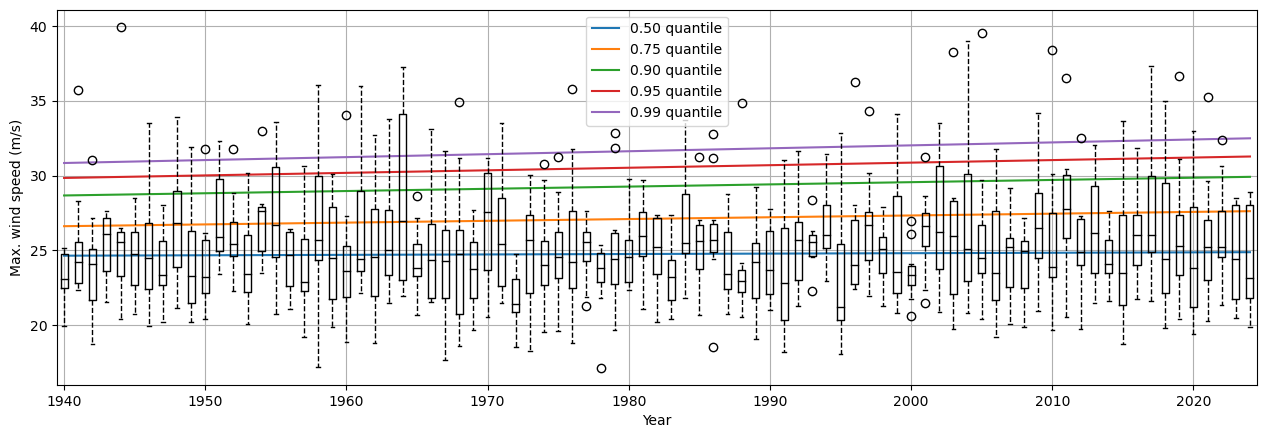

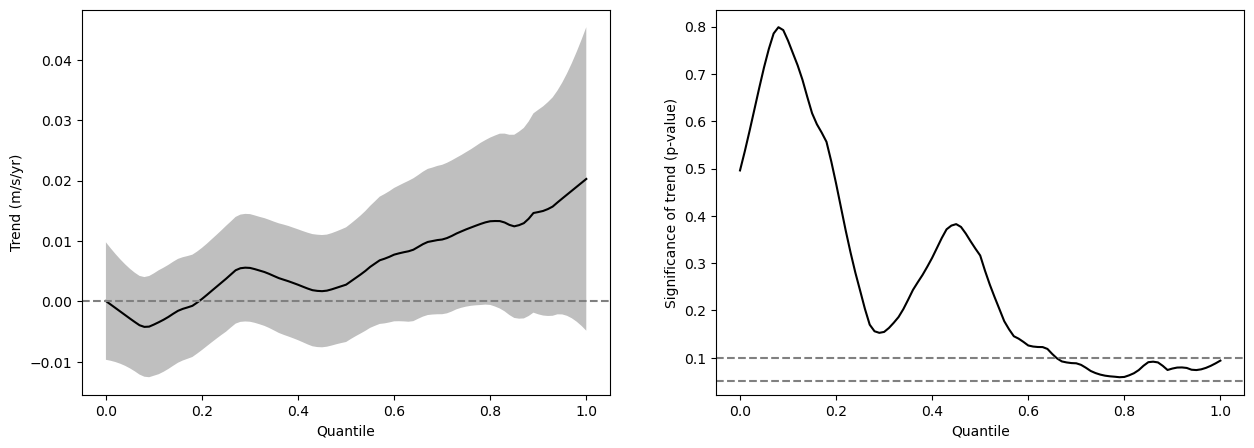

p < 0.05
[]
--------------------------
p < 0.1
[0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79
 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93
 0.94 0.95 0.96 0.97 0.98 0.99 1.  ]


In [20]:
# with linear-least squares
qs_plot = [50, 75, 90, 95, 99]

# full time interval (1940-2025) with four panels
qregs_w = plot_quantile(dfs, 'max_w_all_h_750 (m/s)', quantiles, 'max_w (m/s)', 'Max. wind speed (m/s)', 'Trend (m/s/yr)', qs_plot)

# print significant quantiles for p<0.05 and p<0.1
pvals_w = np.array([i.pvalue for i in qregs_w])
print("p < 0.05")
print(np.where(pvals_w <= 0.05)[0]/100)
print("--------------------------")
print("p < 0.1")
print(np.where(pvals_w <= 0.1)[0]/100)

# Fig. S1A and 1B: Mann-Kendall trend analysis (750 km)

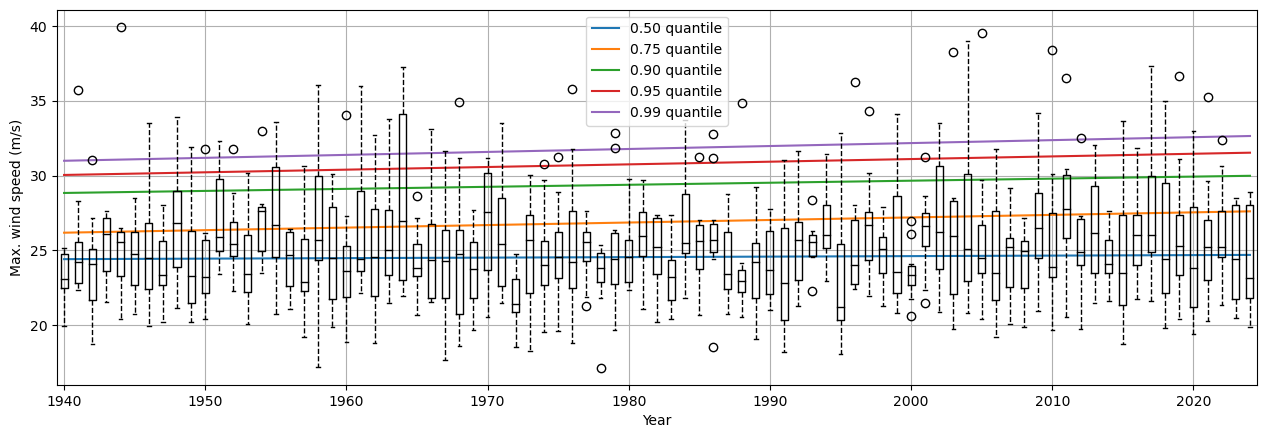

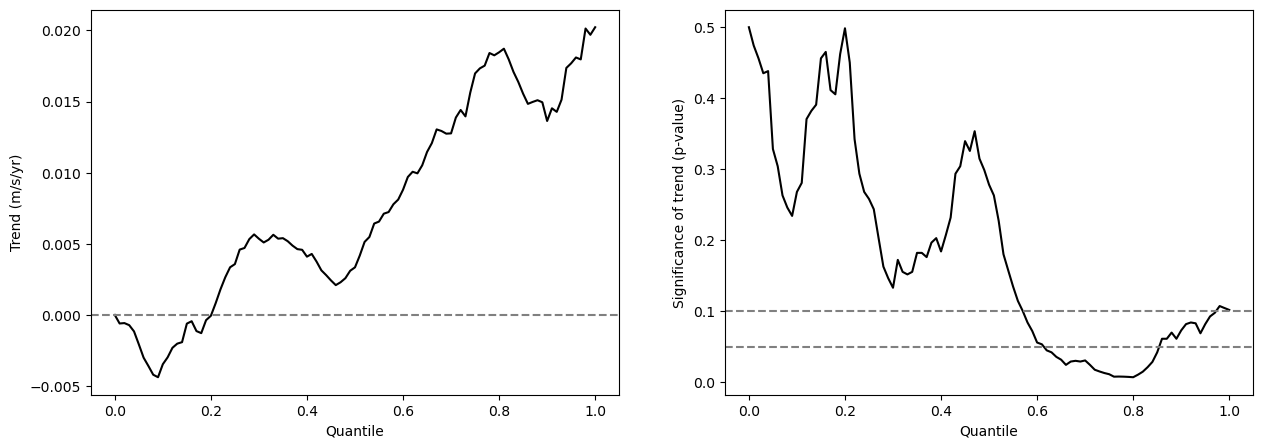

p < 0.05
[0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75
 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85]
--------------------------
p < 0.1
[0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71
 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85
 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97]


In [21]:
# with Mann-Kendall trend analysis
qs_plot = [50, 75, 90, 95, 99]
mks_w = plot_quantile_mk(dfs, 'max_w_all_h_750 (m/s)', quantiles, 'max_w (m/s)', 'Max. wind speed (m/s)', 'Trend (m/s/yr)', qs_plot)

# print significant quantiles for p<0.05 and p<0.1
pvals_w = np.array([i.p/2 for i in mks_w])
print("p < 0.05")
print(np.where(pvals_w <= 0.05)[0]/100)
print("--------------------------")
print("p < 0.1")
print(np.where(pvals_w <= 0.1)[0]/100)